
Data Preprocessing...

Dropping rows which contains NaN or empty values



In [ ]:


import pandas as pd

filed_csv  = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Filed_20220601_20220630.csv"
actual_csv = "/content/drive/MyDrive/Flight_Datas/Flight_Points_Actual_20220601_20220630.csv"
nc_path    = "/content/drive/MyDrive/Flight_Datas/data_stream-oper_stepType-instant.nc"
flights_meta = '/content/drive/MyDrive/Flight_Datas/Flights_20220601_20220630.csv'

df_meta   = pd.read_csv(flights_meta)

df_filed  = pd.read_csv(filed_csv)
df_actual = pd.read_csv(actual_csv)

allowed_segments = ['All-Cargo', 'Mainline', 'Lowcost','Charter','Regional Aircraft',]
df_meta = df_meta[df_meta['STATFOR Market Segment'].isin(allowed_segments)].copy()



In [ ]:
# Filed noktaları
filed_counts = df_filed.groupby("ECTRL ID").size()
# Actual noktaları
actual_counts = df_actual.groupby("ECTRL ID").size()

# Ortalama filed nokta sayısı
ortalama_filed = filed_counts.mean()
# Ortalama actual nokta sayısı
ortalama_actual = actual_counts.mean()

print(f"Bir uçuşta ortalama filed nokta sayısı: {ortalama_filed:.2f}")
print(f"Bir uçuşta ortalama actual nokta sayısı: {ortalama_actual:.2f}")


Bir uçuşta ortalama filed nokta sayısı: 34.62
Bir uçuşta ortalama actual nokta sayısı: 36.73


In [ ]:
print(df_actual.columns.tolist())

['ECTRL ID', 'Sequence Number', 'Time Over', 'Flight Level', 'Latitude', 'Longitude', 'Temp_C', 'DewPoint_C', 'U_Wind_10m', 'V_Wind_10m', 'MSL_Pressure_hPa', 'Surface_Pressure_hPa', 'CloudBase_m', 'LowCloud', 'TotalCloud']


| Segment           | Açıklama                     | Örnekler                |
| ----------------- | ---------------------------- | ----------------------- |
| All-Cargo         | Yalnızca yük taşır           | FedEx, Turkish Cargo    |
| Business Aviation | Özel/VIP uçuşlar             | NetJets, şirket jetleri |
| Charter           | Tarifesiz, toplu uçuşlar     | SunExpress charter      |
| Mainline          | Büyük tarifeli havayolları   | THY, Lufthansa          |
| Lowcost           | Düşük maliyetli havayolları  | Pegasus, Ryanair        |
| Regional Aircraft | Bölgesel kısa mesafe         | AnadoluJet, Air Nostrum |
| Other Types       | Diğer (devlet, askeri, özel) | Ambulans, yangın uçağı  |


In [ ]:
print(df_meta['STATFOR Market Segment'].unique())

['All-Cargo' 'Charter' 'Mainline' 'Lowcost' 'Regional Aircraft']


In [ ]:
print((df_meta['STATFOR Market Segment'] == 'Lowcost').sum())


296393


Adding Destination and Source point informations on route logs

In [ ]:



df_filed.sort_values(["ECTRL ID", "Time Over"], inplace=True)

# 2) Aynı ECTRL ID grubunda önceki ve sonraki geçerli değerlerle impute et
df_filed["CloudBase_m"] = (
    df_filed
      .groupby("ECTRL ID")["CloudBase_m"]
      .apply(lambda s: s.ffill().bfill())
      .reset_index(level=0, drop=True)
)

# 3) Son durumu kontrol et
print("CloudBase_m_filed hâlâ NaN sayısı:", df_filed["CloudBase_m"].isna().sum())

df_filed["CloudBase_m"].fillna(0, inplace=True)

df_actual.sort_values(["ECTRL ID", "Time Over"], inplace=True)

# 2) Aynı ECTRL ID grubunda önceki ve sonraki geçerli değerlerle impute et
df_actual["CloudBase_m"] = (
    df_actual
      .groupby("ECTRL ID")["CloudBase_m"]
      .apply(lambda s: s.ffill().bfill())
      .reset_index(level=0, drop=True)
)

# 3) Son durumu kontrol et
print("CloudBase_m hâlâ NaN sayısı:", df_actual["CloudBase_m"].isna().sum())

df_actual["CloudBase_m"].fillna(0, inplace=True)


CloudBase_m_filed hâlâ NaN sayısı: 49458


<ipython-input-7-4090267285>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filed["CloudBase_m"].fillna(0, inplace=True)


CloudBase_m hâlâ NaN sayısı: 53768


<ipython-input-7-4090267285>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_actual["CloudBase_m"].fillna(0, inplace=True)


Uçuşlar: 100%|██████████| 185485/185485 [37:45<00:00, 81.88it/s]


    ECTRL ID  filed_idx  actual_idx        dist_m  time_diff_s  \
0  252119478          0           1      0.000000        120.0   
1  252119478          1           1      0.000000        780.0   
2  252119478          2           2      0.000000        770.0   
3  252119478          3           3      0.000000        763.0   
4  252119478          4           4      0.000000        779.0   
5  252119478          5           4   5551.193642        832.0   
6  252119478          6           5   6424.181335        837.0   
7  252119478          7           6  20783.082446        806.0   
8  252119478          8           6  21319.184488        926.0   
9  252119478          9           7  31176.884991        675.0   

   filed_Sequence Number     filed_Time Over  filed_Flight Level  \
0                      0 2022-06-01 00:00:00                   0   
1                      1 2022-06-01 00:15:00                   0   
2                      2 2022-06-01 00:16:15                  36   
3

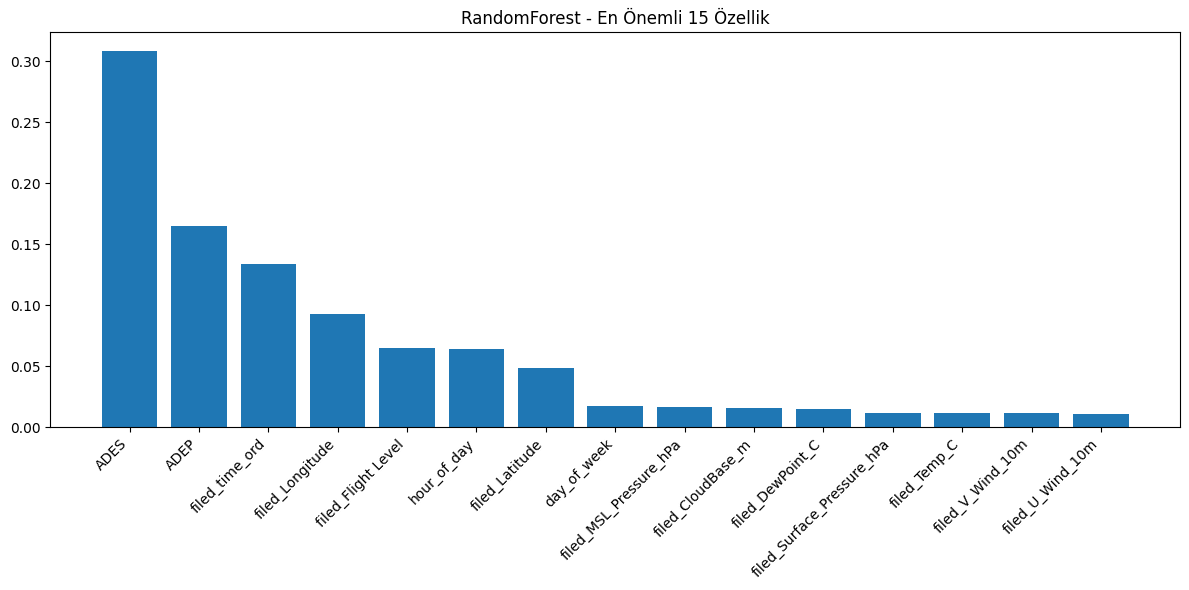

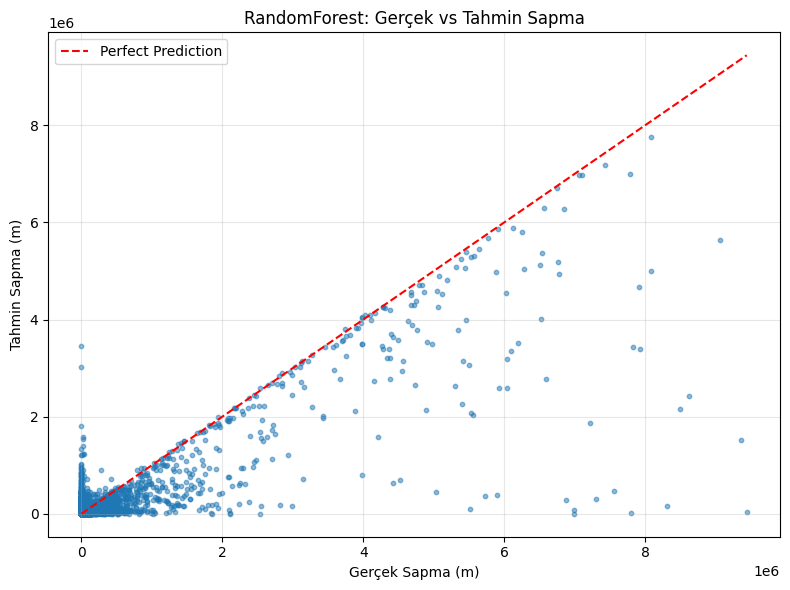


🔄 ExtraTrees eğitiliyor...


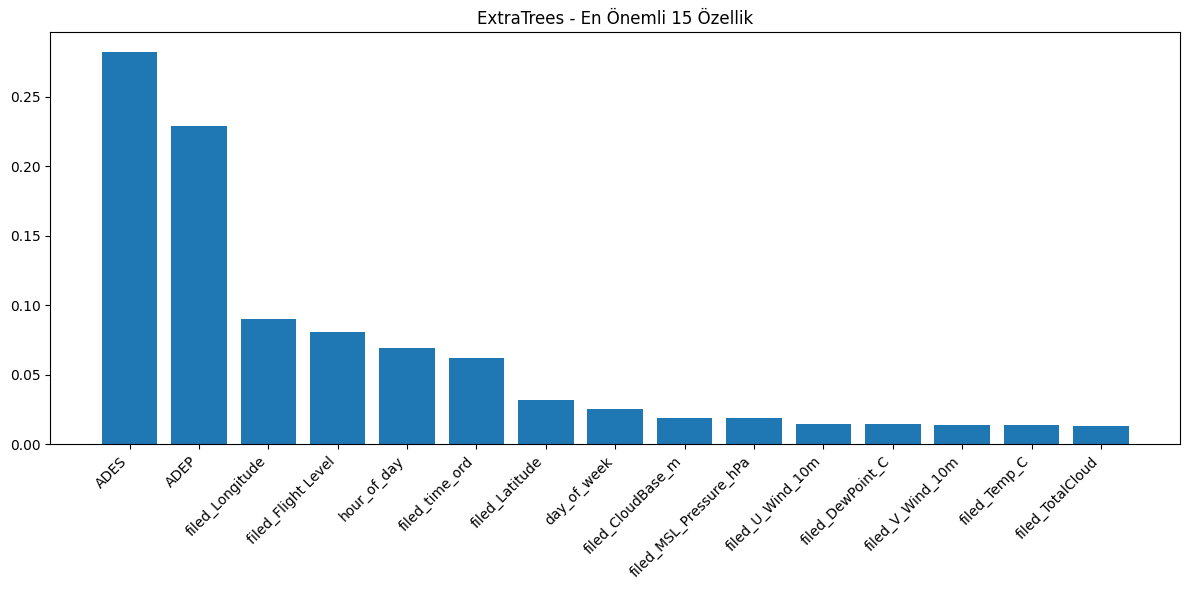

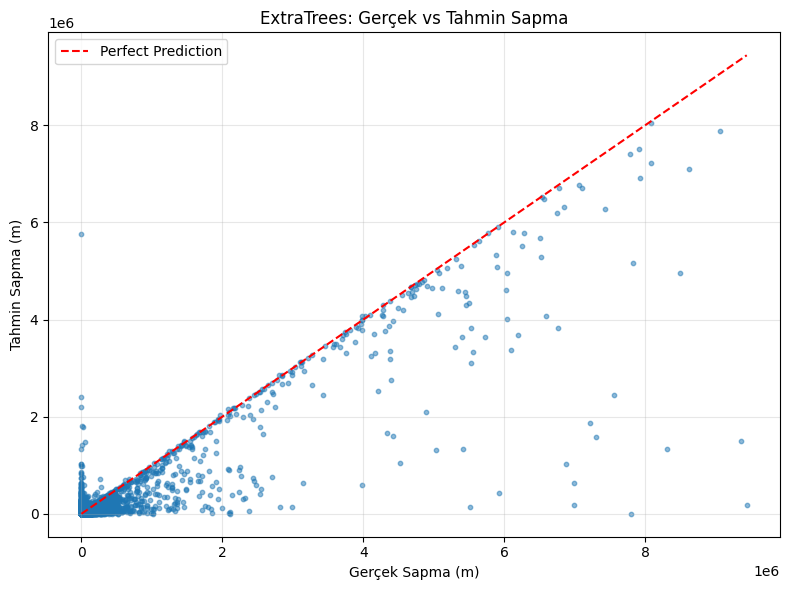


🔄 GradientBoosting eğitiliyor...


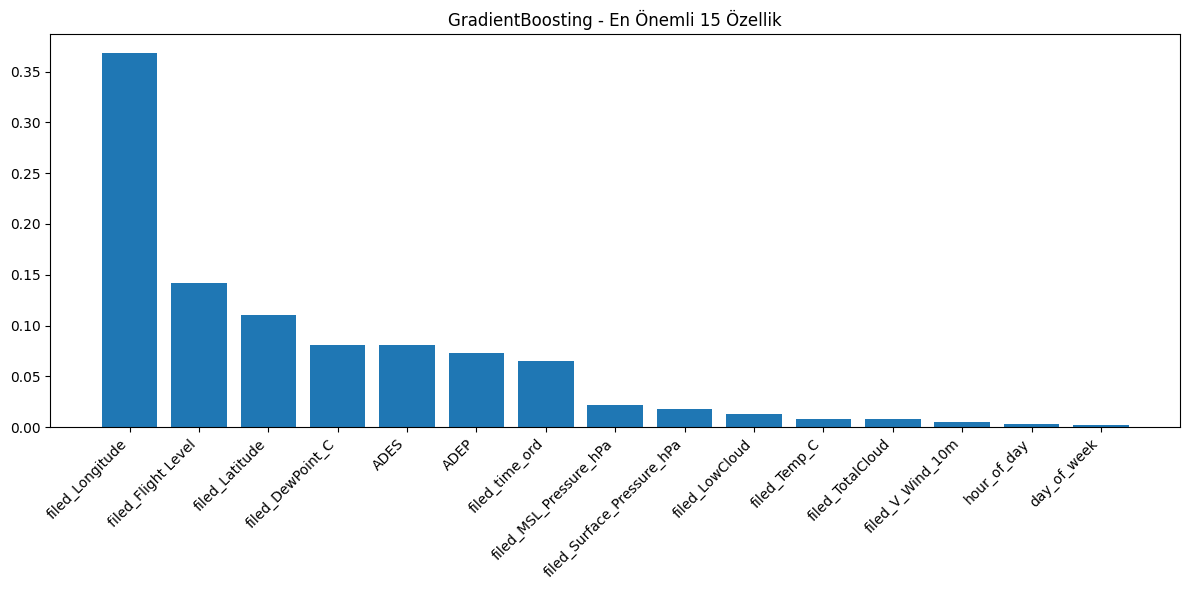

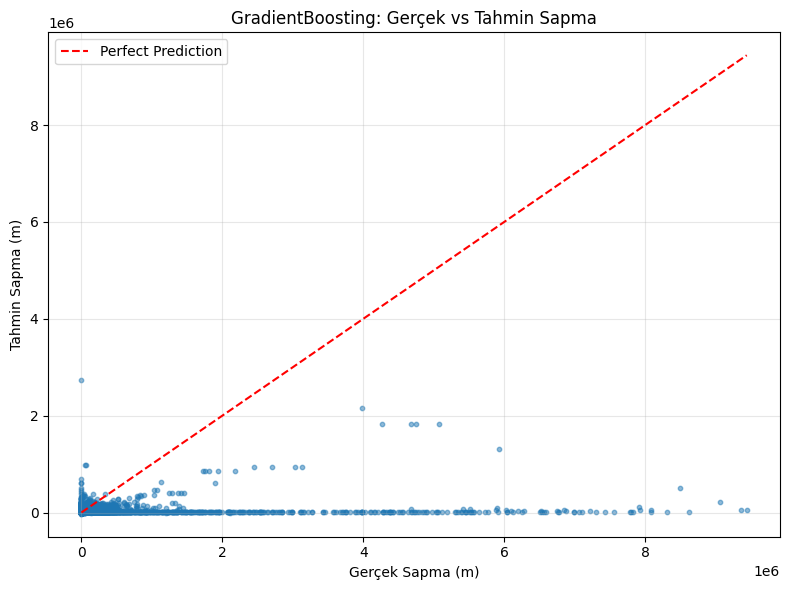


🔄 XGBoost eğitiliyor...


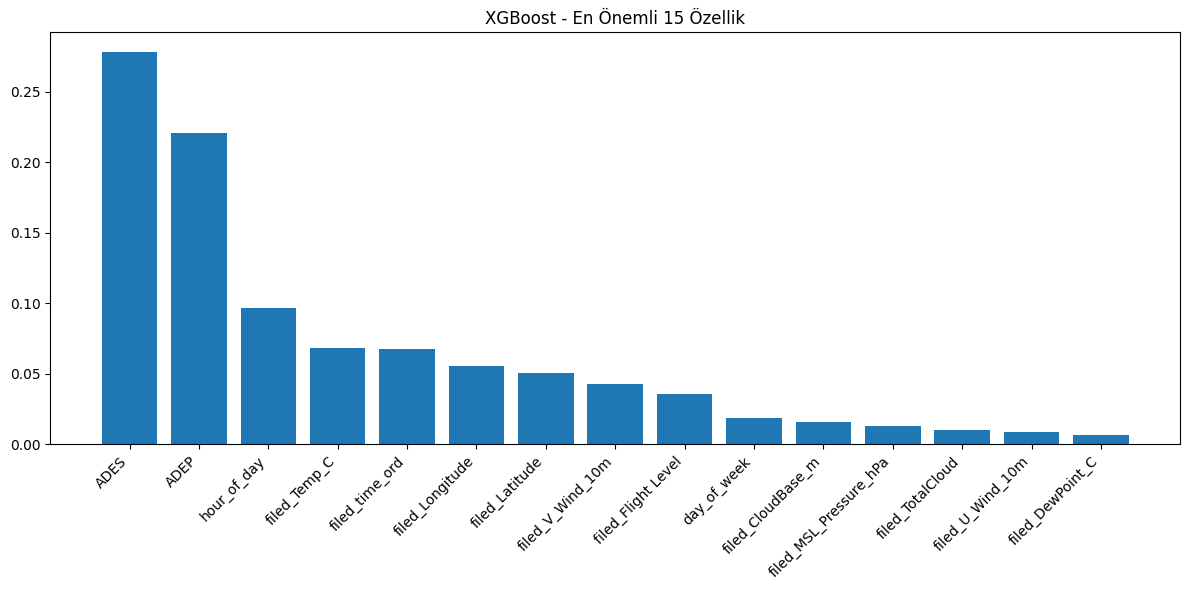

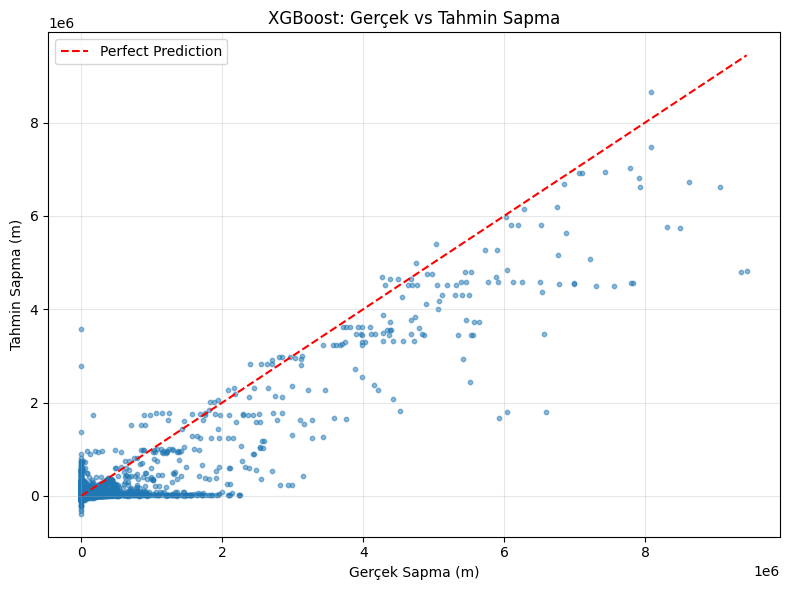


🔄 LightGBM eğitiliyor...


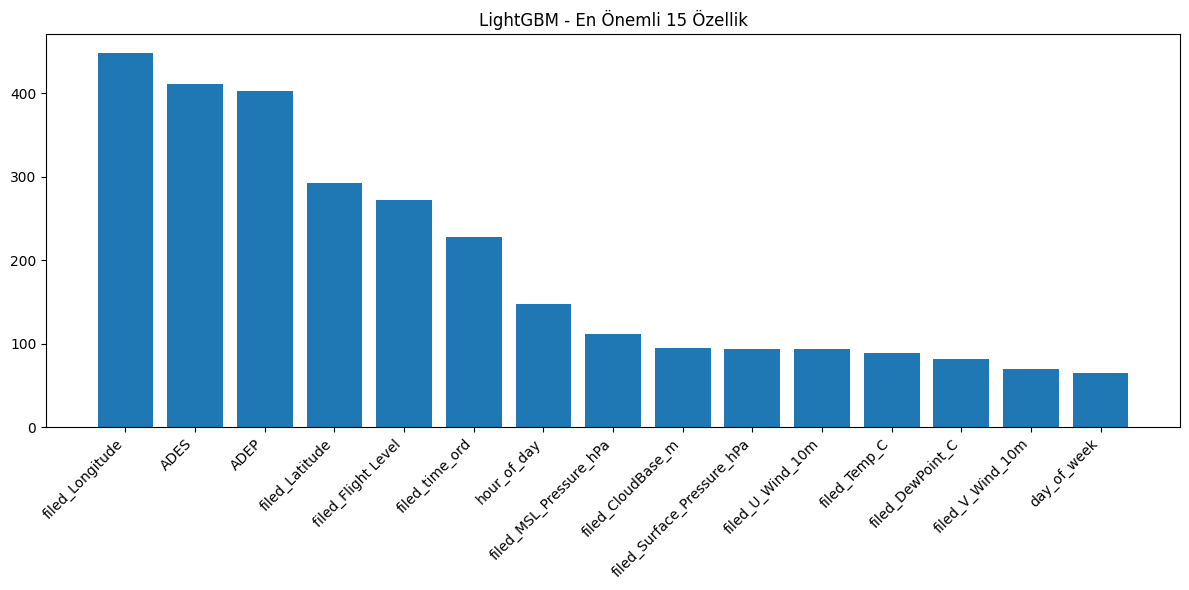

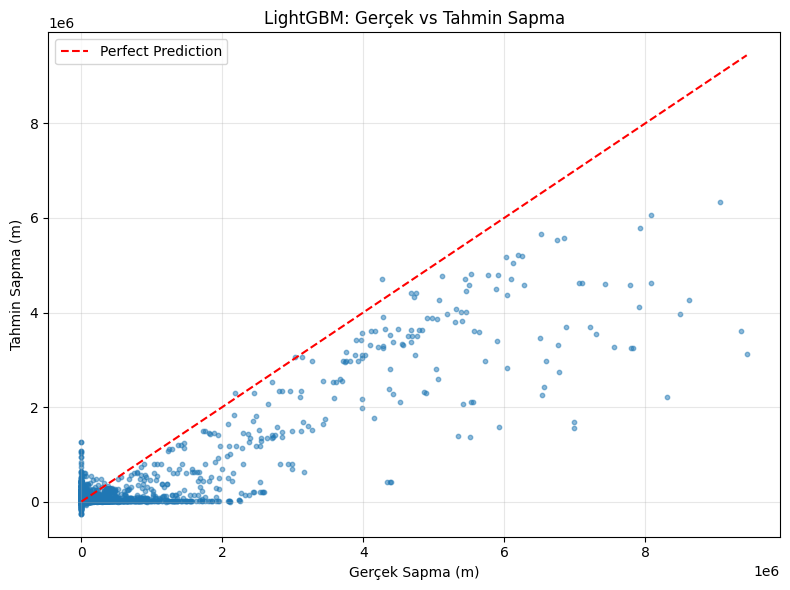


📊 Model Performansları:
              Model       MAE      RMSE    R2
0      RandomForest   7417.78  35140.43  0.71
1        ExtraTrees   7234.49  31008.04  0.77
2  GradientBoosting  14201.47  63667.64  0.03
3           XGBoost  12384.40  31004.51  0.77
4          LightGBM  13014.80  36700.19  0.68

🏆 En iyi model: XGBoost
R² Score: 0.7710
MAE: 12384.40 metre
RMSE: 31004.51 metre

💡 Kullanım örneği:
Bu model sadece filed (planlanan) verileriyle sapma tahmini yapar.


In [ ]:
!pip install xgboost lightgbm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm


df_filed["Time Over"] = pd.to_datetime(
    df_filed["Time Over"],
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)
df_actual["Time Over"] = pd.to_datetime(
    df_actual["Time Over"],
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)

# NaN değerleri temizle
df_filed = df_filed.dropna(subset=["Time Over"])
df_actual = df_actual.dropna(subset=["Time Over"])

# Verileri sırala
df_filed_sorted = df_filed.sort_values(['ECTRL ID', 'Time Over']).reset_index(drop=True)
df_actual_sorted = df_actual.sort_values(['ECTRL ID', 'Time Over']).reset_index(drop=True)

def haversine_np(lat1, lon1, lat2, lon2):
    """Haversine formülü - mesafe hesaplama (metre)"""
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # metre

def haversine(lat1, lon1, lat2, lon2):
    """Haversine formülü - mesafe hesaplama (kilometre)"""
    R = 6371  # Dünya yarıçapı (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Filed ve Actual noktaları eşleştirme
columns = ['Sequence Number', 'Time Over', 'Flight Level', 'Latitude', 'Longitude', 'Temp_C',
           'DewPoint_C', 'U_Wind_10m', 'V_Wind_10m', 'MSL_Pressure_hPa', 'Surface_Pressure_hPa',
           'CloudBase_m', 'LowCloud', 'TotalCloud']

results = []

for fid in tqdm(sorted(set(df_filed['ECTRL ID']) & set(df_actual['ECTRL ID'])), desc='Uçuşlar'):
    filed_f = df_filed[df_filed['ECTRL ID'] == fid].reset_index(drop=True)
    actual_f = df_actual[df_actual['ECTRL ID'] == fid].reset_index(drop=True)
    if actual_f.empty or filed_f.empty:
        continue

    # Koordinatlar ve zaman arrayleri
    filed_times = pd.to_datetime(filed_f["Time Over"]).to_numpy()
    filed_lats  = filed_f["Latitude"].to_numpy()
    filed_lons  = filed_f["Longitude"].to_numpy()
    actual_times = pd.to_datetime(actual_f["Time Over"]).to_numpy()
    actual_lats  = actual_f["Latitude"].to_numpy()
    actual_lons  = actual_f["Longitude"].to_numpy()

    for idx, (lat0, lon0, t0) in enumerate(zip(filed_lats, filed_lons, filed_times)):
        # Hem zaman hem mesafe olarak en yakın actual noktayı bul
        time_diffs = np.abs((actual_times - t0) / np.timedelta64(1, 's'))  # saniye cinsinden
        dists = haversine_np(lat0, lon0, actual_lats, actual_lons)
        # Skor: 5km=1 birim, 10dk=1 birim gibi ağırlık
        combined_score = dists / 5000 + time_diffs / 600
        min_idx = np.argmin(combined_score)

        row = {
            "ECTRL ID": fid,
            "filed_idx": idx,
            "actual_idx": min_idx,
            "dist_m": dists[min_idx],
            "time_diff_s": time_diffs[min_idx],
        }
        # Tüm filed kolonlarını "filed_" prefixiyle ekle
        for col in columns:
            row[f"filed_{col}"] = filed_f.loc[idx, col]
        # Tüm actual kolonlarını "actual_" prefixiyle ekle (sadece sapma hesabı için)
        for col in columns:
            row[f"actual_{col}"] = actual_f.loc[min_idx, col]
        results.append(row)

df_sapma_full = pd.DataFrame(results)
print(df_sapma_full.head(10))
print("Toplam eşleşmiş filed nokta:", len(df_sapma_full))

# Sapma hesaplamaları
df = df_sapma_full.copy()

# Zaman farkı (dakika cinsinden)
zaman_fark_dakika = (df['actual_Time Over'] - df['filed_Time Over']).dt.total_seconds() / 60

# Konum farkı (km cinsinden)
konum_fark_km = df.apply(lambda row: haversine(row['filed_Latitude'], row['filed_Longitude'],
                                               row['actual_Latitude'], row['actual_Longitude']), axis=1)

# Flight Level farkı
irtifa_fark = np.abs(df['filed_Flight Level'] - df['actual_Flight Level'])

# Sonuçları DataFrame'e ekle
df['zaman_fark_dakika'] = zaman_fark_dakika
df['konum_fark_km'] = konum_fark_km
df['irtifa_fark'] = irtifa_fark

# Meta bilgileri ekle
meta_subset = df_meta[["ECTRL ID", "ADEP", "ADES"]]
df_sapma_full = df_sapma_full.merge(meta_subset, on="ECTRL ID", how="left")

print("Ortalama Zaman Sapması (dakika):", np.mean(zaman_fark_dakika))
print("Ortalama Konum Sapması (km):", np.mean(konum_fark_km))
print("Ortalama İrtifa Sapması:", np.mean(irtifa_fark))
print("Medyan Konum Sapması (km):", np.median(konum_fark_km))
print("Toplam eşleşmiş filed nokta:", len(df))

# =============================================================================
# ✅ DÜZELTILMIŞ MODEL EĞİTİMİ - SADECE FİLED VERİLERİ KULLANILIYOR
# =============================================================================

# Kategorik kolonları encode et
for col in ["ADEP", "ADES"]:
    if col in df_sapma_full.columns:
        df_sapma_full[col] = df_sapma_full[col].astype("category").cat.codes.astype("int16")

# Zamanı sayısala çevir
df_sapma_full["filed_time_ord"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).astype(int) // 10**9

# Zaman bazlı özellikler ekle (filed bilgilerinden)
df_sapma_full["hour_of_day"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.hour
df_sapma_full["day_of_week"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.dayofweek
df_sapma_full["month"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.month

# ✅ SADECE FİLED VERİLERİNİ KULLAN - DATA LEAKAGE YOK!
feature_cols = [
    # Filed nokta bilgileri
    "filed_Latitude", "filed_Longitude", "filed_Flight Level",
    "filed_Temp_C", "filed_DewPoint_C",
    "filed_U_Wind_10m", "filed_V_Wind_10m",
    "filed_MSL_Pressure_hPa", "filed_Surface_Pressure_hPa",
    "filed_CloudBase_m", "filed_LowCloud", "filed_TotalCloud",

    # Zaman bilgileri (önceden bilinebilir)
    "filed_time_ord", "hour_of_day", "day_of_week", "month",

    # Havaalanı bilgileri
    "ADEP", "ADES"
]

# Hedef değişken: Sapma miktarı (metre)
y = df_sapma_full["dist_m"].astype("float32").values
X = df_sapma_full[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n📊 Model Özeti:")
print(f"Feature sayısı: {len(feature_cols)}")
print(f"Örnek sayısı: {len(y)}")
print(f"Ortalama sapma: {np.mean(y):.2f} metre")
print(f"Medyan sapma: {np.median(y):.2f} metre")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelleri tanımla
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

results = {}
for name, mdl in models.items():
    print(f"\n🔄 {name} eğitiliyor...")

    # Modeli eğit ve tahmin yap
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)

    # Performans metrikleri
    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }

    # Feature importance görselleştirme
    if hasattr(mdl, "feature_importances_"):
        importances = mdl.feature_importances_
        indices = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(12, 6))
        plt.title(f"{name} - En Önemli 15 Özellik")
        plt.bar(range(15), importances[indices])
        plt.xticks(range(15), [feature_cols[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Scatter plot: Gerçek vs Tahmin
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, preds, alpha=0.5, s=10)
    lim = max(y_test.max(), preds.max())
    plt.plot([0, lim], [0, lim], 'r--', label='Perfect Prediction')
    plt.title(f"{name}: Gerçek vs Tahmin Sapma")
    plt.xlabel("Gerçek Sapma (m)")
    plt.ylabel("Tahmin Sapma (m)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Performans tablosu
metrics_df = pd.DataFrame(results).T.rename_axis("Model").reset_index()
print("\n📊 Model Performansları:")
print(metrics_df.round(2))

# En iyi modeli seç
best_model_name = metrics_df.loc[metrics_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

print(f"\n🏆 En iyi model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['R2']:.4f}")
print(f"MAE: {results[best_model_name]['MAE']:.2f} metre")
print(f"RMSE: {results[best_model_name]['RMSE']:.2f} metre")

# Örnek tahmin fonksiyonu
def predict_deviation(model, filed_data):
    """
    Yeni bir filed nokta için sapma tahmini yapar

    Parameters:
    model: Eğitilmiş ML model
    filed_data: Dict - filed nokta bilgileri

    Returns:
    float: Tahmini sapma (metre)
    """
    # Filed verilerinden feature'ları çıkar
    features = np.array([filed_data[col] for col in feature_cols]).reshape(1, -1)
    prediction = model.predict(features)[0]
    return prediction

print(f"\n💡 Kullanım örneği:")
print("Bu model sadece filed (planlanan) verileriyle sapma tahmini yapar.")

In [ ]:
df_sapma_full = pd.DataFrame(results)
meta_subset = df_meta[["ECTRL ID", "ADEP", "ADES"]]
df_sapma_full = df_sapma_full.merge(meta_subset, on="ECTRL ID", how="left")

df = df_sapma_full.copy().sort_values(['ECTRL ID', 'filed_idx'])

df['filed_Time Over'] = pd.to_datetime(df['filed_Time Over'])
df['filed_time_ord'] = df['filed_Time Over'].view('int64') // 10**9
df['hour_of_day']  = df['filed_Time Over'].dt.hour
df['day_of_week']  = df['filed_Time Over'].dt.dayofweek
df['month']        = df['filed_Time Over'].dt.month
print(df_sapma_full.head(10))
print("Toplam eşleşmiş filed nokta:", len(df_sapma_full))

# Sapma hesaplamaları
df = df_sapma_full.copy()

# Zaman farkı (dakika cinsinden)
zaman_fark_dakika = (df['actual_Time Over'] - df['filed_Time Over']).dt.total_seconds() / 60

# Konum farkı (km cinsinden)
konum_fark_km = df.apply(lambda row: haversine(row['filed_Latitude'], row['filed_Longitude'],
                                               row['actual_Latitude'], row['actual_Longitude']), axis=1)

# Flight Level farkı
irtifa_fark = np.abs(df['filed_Flight Level'] - df['actual_Flight Level'])

# Sonuçları DataFrame'e ekle
df['zaman_fark_dakika'] = zaman_fark_dakika
df['konum_fark_km'] = konum_fark_km
df['irtifa_fark'] = irtifa_fark

# Meta bilgileri ekle





print("Ortalama Zaman Sapması (dakika):", np.mean(zaman_fark_dakika))
print("Ortalama Konum Sapması (km):", np.mean(konum_fark_km))
print("Ortalama İrtifa Sapması:", np.mean(irtifa_fark))
print("Medyan Konum Sapması (km):", np.median(konum_fark_km))
print("Toplam eşleşmiş filed nokta:", len(df))

# =============================================================================
# ✅ DÜZELTILMIŞ MODEL EĞİTİMİ - SADECE FİLED VERİLERİ KULLANILIYOR
# =============================================================================

# Kategorik kolonları encode et
for col in ["ADEP", "ADES"]:
    if col in df_sapma_full.columns:
        df_sapma_full[col] = df_sapma_full[col].astype("category").cat.codes.astype("int16")

# Zamanı sayısala çevir
df_sapma_full["filed_time_ord"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).astype(int) // 10**9

# Zaman bazlı özellikler ekle (filed bilgilerinden)
df_sapma_full["hour_of_day"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.hour
df_sapma_full["day_of_week"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.dayofweek
df_sapma_full["month"] = pd.to_datetime(df_sapma_full["filed_Time Over"]).dt.month

df_sapma_full = df_sapma_full.sort_values(['ECTRL ID', 'filed_idx'])
df_sapma_full['prev_dev_m'] = df_sapma_full.groupby('ECTRL ID')['dist_m'].shift(1).fillna(0)

#df = df_sapma_full.copy().sort_values(['ECTRL ID', 'filed_idx'])

# Zaman bazlı
df['filed_Time Over'] = pd.to_datetime(df['filed_Time Over'])
df['filed_time_ord'] = df['filed_Time Over'].astype(int) // 10**9
df['hour_of_day']  = df['filed_Time Over'].dt.hour
df['day_of_week']  = df['filed_Time Over'].dt.dayofweek
df['month']        = df['filed_Time Over'].dt.month



<ipython-input-24-2313496210>:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['filed_time_ord'] = df['filed_Time Over'].view('int64') // 10**9


    ECTRL ID  filed_idx  actual_idx      dist_m  time_diff_s  \
0  252119478          0           1    0.000000        120.0   
1  252119478          1           7  112.465741          0.0   
2  252119478          2           8  120.941981         32.0   
3  252119478          3           9  133.762705         12.0   
4  252119478          4           9  129.181384         41.0   
5  252119478          5           9  124.886844         94.0   
6  252119478          6          10  161.110309         72.0   
7  252119478          7          11  169.079228          9.0   
8  252119478          8          11  144.982691        111.0   
9  252119478          9          12  195.055126        165.0   

   filed_Sequence Number     filed_Time Over  filed_Flight Level  \
0                      0 2022-06-01 00:00:00                   0   
1                      1 2022-06-01 00:15:00                   0   
2                      2 2022-06-01 00:16:15                  36   
3                      

In [ ]:
# Ardışık sapma

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense
df['prev_dev_m'] = df.groupby('ECTRL ID')['dist_m'].shift(1).fillna(0)

# Kategorik encode
for col in ['ADEP','ADES']:
    df[col] = LabelEncoder().fit_transform(df[col])


# Feature ve target listeleri
feature_cols = [
    'filed_Latitude','filed_Longitude','filed_Flight Level',
    'filed_Temp_C','filed_DewPoint_C','filed_U_Wind_10m','filed_V_Wind_10m',
    'filed_MSL_Pressure_hPa','filed_Surface_Pressure_hPa',
    'filed_CloudBase_m','filed_LowCloud','filed_TotalCloud',
    'filed_time_ord','hour_of_day','day_of_week','month',
    'ADEP','ADES','prev_dev_m'
]
target_col = 'dist_m'

# NaN/inf temizliği
df[feature_cols] = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0)

# --- 4) Zaman serisi dizilerine dönüştür ---
def make_sequences(df, feature_cols, target_col, seq_len=50):
    X, y = [], []
    for fid, grp in df.groupby('ECTRL ID'):
        arr = grp[feature_cols + [target_col]].values
        n = len(arr)
        if n < seq_len:
            continue
        for i in range(n - seq_len + 1):
            window = arr[i:i+seq_len]
            X.append(window[:, :-1])
            y.append(window[:, -1].reshape(-1,1))
    return np.array(X), np.array(y)

SEQ_LEN = 50
X, y = make_sequences(df, feature_cols, target_col, seq_len=SEQ_LEN)
print("X shape:", X.shape)  # (örnek_sayısı, 50, özellik_sayısı)
print("y shape:", y.shape)  # (örnek_sayısı, 50, 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) Input katmanı ile başla
inputs = Input(shape=(SEQ_LEN, len(feature_cols)), name="inputs")

# 2) Masking yerine doğrudan LSTM (tüm diziler eşit uzunlukta)
x = LSTM(64, return_sequences=True)(inputs)
x = LSTM(32, return_sequences=True)(x)

# 3) Her zaman adımı için tek bir tahmin
outputs = TimeDistributed(Dense(1), name="outputs")(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# 4) Eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

# --- 7) Değerlendirme ---
# Tahminleri al, flatten edip klasik metriklere bakabiliriz
y_pred = model.predict(X_val)
y_true = y_val.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae  = mean_absolute_error(y_true, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
r2   = r2_score(y_true, y_pred_flat)

print(f"Test MAE:  {mae:.2f} m")
print(f"Test RMSE: {rmse:.2f} m")
print(f"Test R2:   {r2:.2f}")

X shape: (1000278, 50, 19)
y shape: (1000278, 50, 1)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 50, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (TimeDistributed)       │ (None, 50, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 509s 20ms/step - loss: 150219.8594 - val_loss: 124384.8828
Epoch 2/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 505s 20ms/step - loss: 121277.6562 - val_loss: 124377.6406
Epoch 3/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 506s 20ms/step - loss: 124204.1797 - val_loss: 124378.1719
Epoch 4/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 505s 20ms/step - loss: 121752.9766 - val_loss: 124372.9453
Epoch 5/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 507s 20ms/step - loss: 122909.1328 - val_loss: 124373.1172
Epoch 6/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 509s 20ms/step - loss: 123032.7422 - val_loss: 124366.5156
Epoch 7/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 506s 20ms/step - loss: 122291.9219 - val_loss: 124361.0547
Epoch 8/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 506s 20ms/step - loss: 122268.9688 - val_loss: 124358.3516
Epoch 9/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 506s 20ms/step - loss: 122580.3203 - val_loss: 124365.9844
Epoch 10/20
25007/25007 ━━━━━━━━━━━━━━━━━━━━ 506s 20ms/step - loss: 12282

In [ ]:
model.save("sapma_model.keras")


In [ ]:
# -----------------------------------------------------------------------
# Yol Rotası Toplam Mesafe Hesaplama
# -----------------------------------------------------------------------
def calculate_planned_distance(filed_df):
    # Ardışık filed noktalar arası toplam mesafe (kilometre)
    lats = filed_df['Latitude'].values
    lons = filed_df['Longitude'].values
    if len(lats) < 2:
        return 0.0
    segs = [
        haversine(lats[i], lons[i], lats[i+1], lons[i+1])
        for i in range(len(lats)-1)
    ]
    return sum(segs)

# -----------------------------------------------------------------------
# Uçuş Bazında Yüzde Sapma Hesaplama
# -----------------------------------------------------------------------
def flight_deviation_percentage(model, df_filed, feature_cols):
    results = []
    for fid in sorted(df_filed['ECTRL ID'].unique()):
        sub = df_filed[df_filed['ECTRL ID'] == fid].reset_index(drop=True)
        planned_km = calculate_planned_distance(sub)
        if planned_km <= 0:
            continue
        X_sub = sub[feature_cols].values
        preds = model.predict(X_sub)             # Tahmini sapma (metre)
        total_dev_m = np.sum(preds)              # Toplam sapma (metre)
        percent_dev = total_dev_m / (planned_km*1000) * 100
        results.append({
            'ECTRL ID': fid,
            'planned_distance_km': planned_km,
            'total_deviation_m': total_dev_m,
            'percent_deviation': percent_dev
        })
    return pd.DataFrame(results)

# En iyi model ile tüm uçuşlar için yüzde sapmayı hesapla
route_stats = flight_deviation_percentage(best_model, df_sapma_full, feature_cols)
print(route_stats.head())
print("Genel Ortalama % Sapma:", route_stats['percent_deviation'].mean())
